In [1]:
print("listing package versions... ")
import sys
print("python:", sys.version)
import pickle as pkl
import seaborn as sns
print("seaborn:", sns.__version__)
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib:", mpl.__version__)
import numpy as np
print("numpy:", np.__version__)
import numba as nb
print("numba:", nb.__version__)
import scipy as sp
print("scipy:", sp.__version__)
import os
from pathlib import Path
%matplotlib inline

listing package versions... 
python: 3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
seaborn: 0.9.0
matplotlib: 2.2.3
numpy: 1.15.1
numba: 0.39.0
scipy: 1.1.0


In [2]:
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = 8,4

sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]})

pardir=Path(os.getcwd()).parent.parent
datadir=str(pardir) +'/Data'

In [3]:
print("picking a dataset...")
#industries: leg, mil, sci, edu, tec
industry='edu'
#weights: 55, 80
weight='80'
#fc is the scaling factor
fc=8

picking a dataset...


In [4]:
print("loading data...")
[PART,DATA]=pkl.load(open(datadir+"/derive/"+industry+weight+"j.pkl", "rb"))

print('variables:',DATA.columns.values)
print('observations =',len(DATA))
print('participation:',PART)

mydir=datadir+"/derive/"+industry+weight+"/"

try:
    os.stat(mydir)
except:
    os.mkdir(mydir) 

loading data...
variables: ['meanqs' 'meanps' 'means' 'sapp_s' 'sapp_ps' 'sapp_qs' 'sapp_res' 'fir_p'
 'las_p' 'win_p' 'win_s' 'l' 'r' 'rr' 'npnum' 'npnum_left' 'npnum_right'
 'npY' 'npM' 'npD' 'm_pri']
observations = 225
participation: [[2, 3, 4, 5], [58, 19, 8, 4]]


# Part 1. Estimate the score distribution, and the strategies. 

## For tractability, I snap it all to the grid of 100*fc+1 points, where fc is the scaling factor that controls the precision of the whole thing

## Here I have some simulated data

/users/nemo/conda/envs/py37an/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


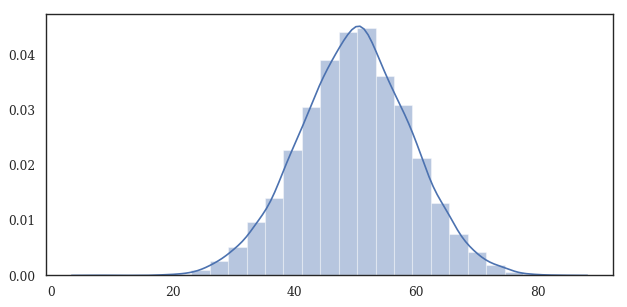

In [5]:
#simulate data
def make_data(N):
    x = 9*fc*np.random.standard_normal(N)
    return x

data = ((make_data(10000)+(fc*50)))
ddata=[]
for i in range(0,len(data)):
    if data[i]<=100*fc and data[i]>=0:
        ddata.append(data[i])
mydata=np.array(ddata).astype(int)
sns.distplot(mydata/fc, bins=25)
plt.tight_layout()

## Here is our actual data. I originally started with the residual score distribution, because that's what the bidder is playing against. But I also tried the plain average bid as well.

/users/nemo/conda/envs/py37an/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


data shape: (225,)


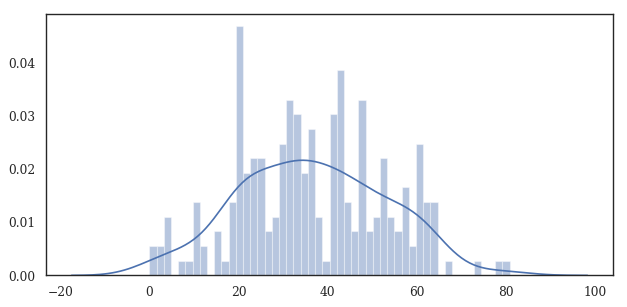

In [6]:
# I scale the distribution by the factor fc, for easy computation
DATA_res=np.multiply(fc,DATA.sapp_res.values).astype(int)
DATA_s=np.multiply(fc,DATA.sapp_s.values).astype(int)

#these are the final scores
mydata=DATA_res

sns.distplot(mydata/fc, bins=50)
plt.tight_layout()
print('data shape:',DATA_res.shape)

## The average bid (orange) distribution vs the residual bid (blue) distribution

225 225


/users/nemo/conda/envs/py37an/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


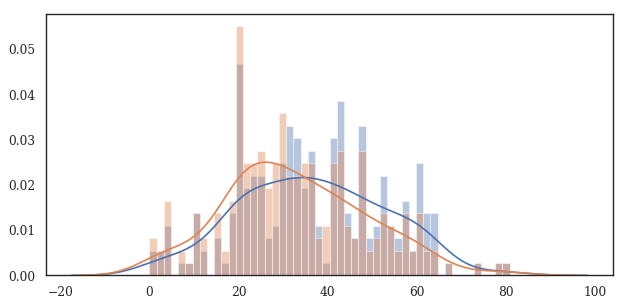

In [7]:
print(len(DATA_res),len(DATA_s))
sns.distplot(DATA_res/fc, bins=50)
sns.distplot(DATA_s/fc, bins=50)
plt.tight_layout()

## Here are all the routines for part 1

In [8]:
#this function constructs the triweight kernel
@nb.jit(nopython=True)
def kernel(band):
    return np.array([np.power(1-np.power((band-x)/band,2),3) for x in range(1,band+1)]
                    +[np.power(1-np.power(x/band,2),3) for x in range(1,band)])

#this function counts the occurences of each observation and places them on a grid
#was just curious how much speed I would gain with that... 
#the answer is not very much unless you have A LOT of data compared to the size of the grid
@nb.jit(nopython=True)
def gcounts(data, grid):
    for x in data:
        grid[x]+=1

#naive kernel smoothing implementation, very fast
@nb.jit(nopython=True)
def naivepdf(grid, band, pdf, ker):
    imax=len(grid)
    for i in range(0,imax):
        left=max(i-band,0)
        right=min(i+band,imax)
        for j in range(left,right):
            pdf[i]+=grid[j]*ker[j-i+band]
            
#cdf is obtained by integrating the pdf, very fast
@nb.jit(nopython=True)
def naivecdf(pdf,cdf):
    for i in range(0,len(cdf)):
        for j in range(0,i):
            cdf[i]=cdf[i]+pdf[j]


#this function maximizes the profit
@nb.jit(nopython=True)
def profits(prof1, prof2, ncdf):
    prof2=np.multiply(prof2, ncdf)
    for i in range(0,len(prof1)):
        prof1[i]=np.argmax(prof2[i,:])
    return prof1

#compute the (inverse? whatever) hazard ratio
@nb.jit(nopython=True)
def hazard(cdf, pdf):
    return cdf/pdf

#this is the main function
@nb.jit(nopython=True)
def step1(mydata, fc, grid, pdf, cdf, prof2, prof1):
    #pick the bandwidth with Silverman rule
    band=max(int(1.06*2.987*np.power(len(mydata),-1/5)*np.std(mydata)),1)
    ker=kernel(band+1)
    gcounts(mydata, grid)
    naivepdf(grid, band, pdf, ker)
    naivecdf(pdf, cdf)
    ncdf=cdf/np.max(cdf)
    
    #to normalize the density, I need to divide it by the sum
    #but then also rescale it back to [0,100], thus multiply by fc  
    npdf=fc*pdf/np.sum(pdf)
    
    sigma=profits(prof1, prof2, ncdf)
    
    #the inverse hazard rate maps into [0,100]
    haz=hazard(ncdf, npdf)
    return ncdf, npdf, sigma, haz, band

### this is the residual (green)

In [9]:
grid=np.zeros(100*fc+1, int)

#leave a 1 in the pdf for division
pdf=np.ones(100*fc+1, float)*0.0001

cdf=np.zeros(100*fc+1, float)
prof1=np.zeros(100*fc+1, int)
prof2=np.array([[th-s for s in range(0,100*fc+1)] for th in range(0,100*fc+1)], int)

ncdf, npdf, sigma, haz, band = step1(DATA_res, fc, grid, pdf, cdf, prof2, prof1)

plt.plot(np.divide(range(0,len(pdf)),fc), npdf, '-', markersize=1,color= 'green')
plt.tight_layout()

### this is the average (blue)

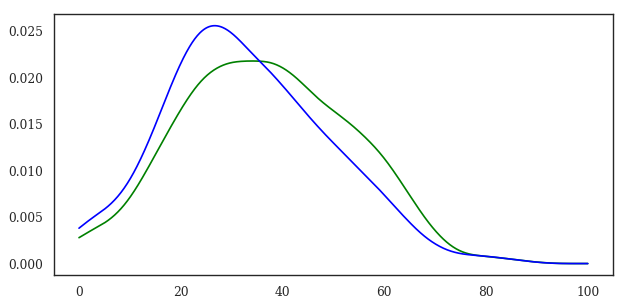

In [10]:
grid=np.zeros(100*fc+1, int)

#leave a 1 in the pdf for division
pdf=np.ones(100*fc+1, float)*0.0001

cdf=np.zeros(100*fc+1, float)
prof12=np.zeros(100*fc+1, int)
prof22=np.array([[th-s for s in range(0,100*fc+1)] for th in range(0,100*fc+1)], int)

ncdf2, npdf2, sigma2, haz2, band2 = step1(DATA_s, fc, grid, pdf, cdf, prof22, prof12)

plt.plot(np.divide(range(0,len(npdf)),fc), npdf, '-', markersize=1,color= 'green')
plt.plot(np.divide(range(0,len(npdf2)),fc), npdf2, '-', markersize=1,color= 'blue')
plt.tight_layout()

### Here is the reconstructed residual using participation frequencies (red)

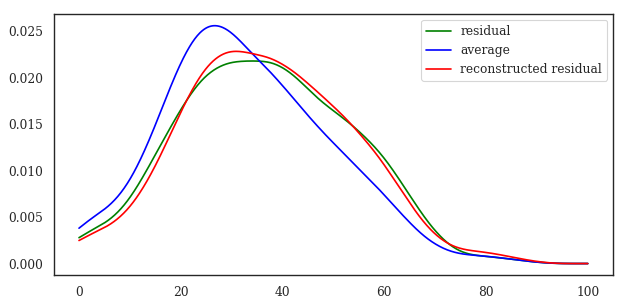

In [11]:
frequencies=np.array(PART[1])/np.sum(PART[1])
powers=np.array(PART[0])
ncdf3=np.zeros(100*fc+1, float)
for i in range(0,100*fc+1):
    for j in range(0,len(powers)):
        ncdf3[i]+=np.power(ncdf2[i],powers[j]-1)*frequencies[j]
        
# I need to recompute the new density
npdf3=np.zeros(100*fc+1, float)  
for i in range(0,100*fc):
    npdf3[i]=(ncdf3[i+1]-ncdf3[i])*fc

prof13=np.zeros(100*fc+1, int)
prof23=np.array([[th-s for s in range(0,100*fc+1)] for th in range(0,100*fc+1)], int)    
    
sigma3=profits(prof13, prof23, ncdf3)
haz3=hazard(ncdf3, npdf3)

plt.plot(np.divide(range(0,len(npdf)),fc), npdf, '-', markersize=1,color= 'green', label='residual')
plt.plot(np.divide(range(0,len(npdf2)),fc), npdf2, '-', markersize=1,color= 'blue', label='average')
plt.plot(np.divide(range(0,len(npdf3)),fc), npdf3, '-', markersize=1,color= 'red', label='reconstructed residual')
plt.legend()
plt.tight_layout()

## The PDF looks pretty good with vanilla KDE, because the distribution is already fairly normal and so the bandwidth (Silverman) rule actually makes sense here

/users/nemo/conda/envs/py37an/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


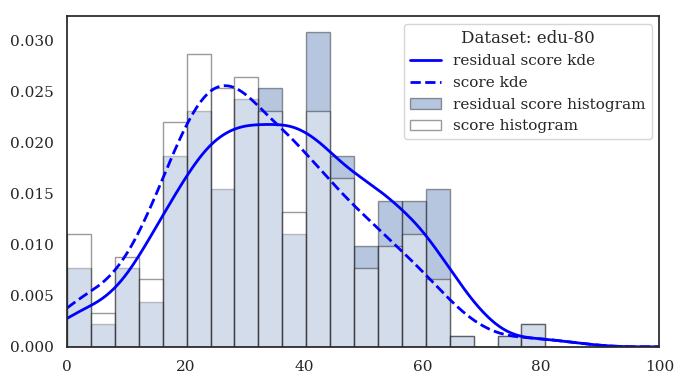

In [12]:
import matplotlib.patches as mpatches

mpl.rcParams['hatch.linewidth'] = 1.5 

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = 7,4

sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]})

fig=sns.distplot(DATA_res/fc, bins=20, label='residual score histogram', hist_kws={"edgecolor":[0.01, 0.01, 0.01, 1]},kde_kws={"linewidth": 0})
fig=sns.distplot(DATA_s/fc, bins=20, label='score histogram', hist_kws={"color":[1, 1, 1, 0],"edgecolor":[0.01, 0.01, 0.01, 1]},kde_kws={"linewidth": 0})
plt.plot(np.divide(range(0,len(pdf)),fc), npdf, '-', markersize=1,color= 'blue', label='residual score kde', linewidth=2)
plt.plot(np.divide(range(0,len(pdf)),fc), npdf2, '--', markersize=1,color= 'blue', label='score kde', linewidth=2)
#plt.plot(np.divide(range(0,len(pdf)),fc), npdf3, '-', markersize=1,color= 'red', label='reconstructed residual')
plt.legend(title='Dataset: edu-80')
plt.xlim((0,100))

#for thisbar in fig.patches[0:20]:
#    # Set a different hatch for each bar
#    thisbar.set_hatch('\\\\\\')
    
#for thisbar in fig.patches[20:40]:
#    # Set a different hatch for each bar
#    thisbar.set_hatch('///')

plt.tight_layout()

plt.savefig(industry+weight+'_histogram_one.pdf', bbox_inches='tight')

## I choose the smooth CDF (not the ugly empirical) because it is better to optimize against

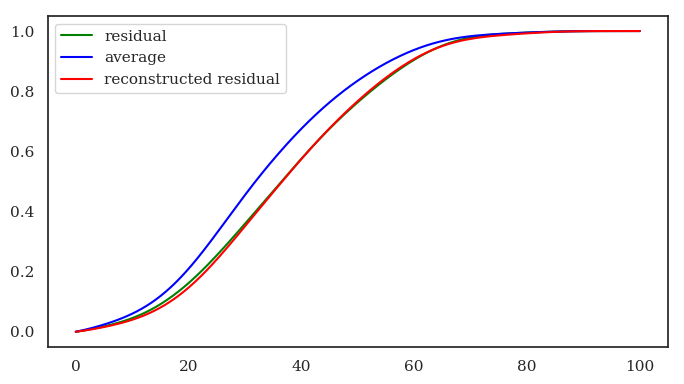

In [13]:
plt.plot(np.divide(range(0,len(pdf)),fc), ncdf, '-', markersize=1,color= 'green', label='residual')
plt.plot(np.divide(range(0,len(pdf)),fc), ncdf2, '-', markersize=1,color= 'blue', label='average')
plt.plot(np.divide(range(0,len(pdf)),fc), ncdf3, '-', markersize=1,color= 'red', label='reconstructed residual')
plt.legend()
plt.tight_layout()

In [14]:
addr=mydir+industry+weight+"j_cdfpdf_"+str(fc)+".pkl"
pkl.dump([ncdf,npdf],open(addr, "wb"))
addr=mydir+industry+weight+"j_cdfpdf2_"+str(fc)+".pkl"
pkl.dump([ncdf2,npdf2],open(addr, "wb"))

## The strategy as an extremum estimator

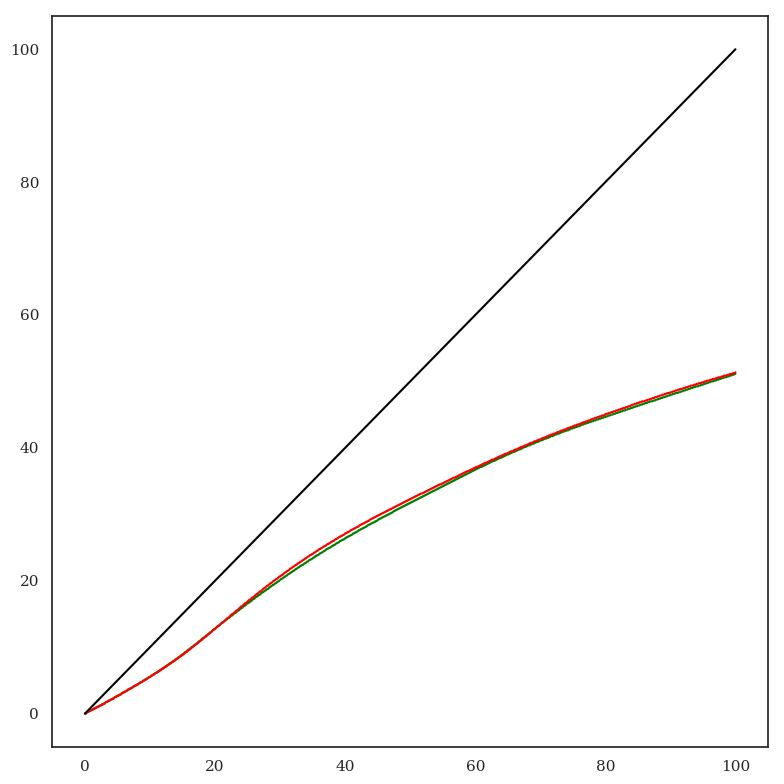

In [15]:
mpl.rcParams['figure.figsize'] = 8,8

plt.plot(np.divide(range(0,len(pdf)),fc), np.divide(prof1,fc), '-', markersize=1,color= 'green')
plt.plot(np.divide(range(0,len(pdf)),fc), np.divide(prof13,fc), '-', markersize=1,color= 'red')
plt.plot(np.divide(range(0,len(pdf)),fc), np.divide(range(0,len(pdf)),fc), '-', markersize=1,color= 'black')
plt.tight_layout()

## Alternatively the inverse strategy can be obtained using a markup equal to the inverse hazard rate, which will mirror the strategy obtained as an extremum estimator

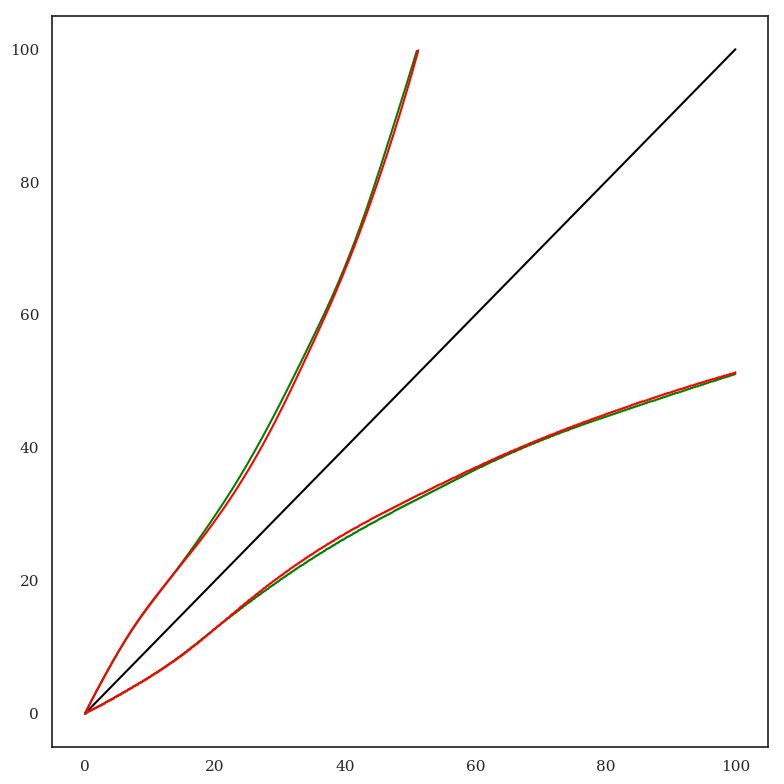

In [16]:
mprof=max(prof1)
mprof3=max(prof13)

plt.plot(np.divide(range(0,len(pdf)),fc), np.divide(range(0,len(pdf)),fc), '-', markersize=1,color= 'black')
plt.plot(np.divide(range(0,mprof),fc), np.array(range(0,mprof))/fc+np.array(haz)[0:mprof], '-', markersize=1,color= 'green')
plt.plot(np.divide(range(0,mprof3),fc), np.array(range(0,mprof3))/fc+np.array(haz3)[0:mprof3], '-', markersize=1,color= 'red')

plt.plot(np.divide(range(0,len(pdf)),fc), np.divide(sigma,fc), '-', markersize=1,color= 'green')
plt.plot(np.divide(range(0,len(pdf)),fc), np.divide(sigma3,fc), '-', markersize=1,color= 'red')
plt.tight_layout()

## Store the results

In [17]:
haz=np.array(haz)
haz3=np.array(haz3)

#using residual
addr=mydir+industry+weight+"j_strategy_"+str(fc)+".pkl"
pkl.dump([sigma,haz],open(addr, "wb"))

#using reconstructed residual
addr=mydir+industry+weight+"j_strategy3_"+str(fc)+".pkl"
pkl.dump([sigma3,haz3],open(addr, "wb"))